In [ ]:
import sys
print(sys.executable)

Data loading and setup


In [13]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# =====================================================
# STATE CLEANING (CANONICAL + TYPO FIXES)
# =====================================================
def clean_state(state):
    if pd.isna(state):
        return np.nan

    state = str(state).strip().lower()
    state = state.replace("&", "and")
    state = " ".join(state.split())

    # ---- Explicit typo & alias handling ----
    alias_map = {
        # West Bengal (ALL variants & typos)
        "west bengal": "WestBengal",
        "westbengal": "WestBengal",
        "west bangal": "WestBengal",
        "westbangal": "WestBengal",
        "west bengol": "WestBengal",
        "westbengol": "WestBengal",

        # Delhi
        "nct of delhi": "Delhi",

        # Jammu & Kashmir
        "jammu and kashmir": "JammuAndKashmir",
        "jammu kashmir": "JammuAndKashmir",

        # Dadra / Daman (pre-merge)
        "dadra and nagar haveli": "DadraAndNagarHaveli",
        "daman and diu": "DamanAndDiu",
    }

    if state in alias_map:
        return alias_map[state]

    # ---- Canonical names ----
    state_map = {
        "andhra pradesh": "AndhraPradesh",
        "arunachal pradesh": "ArunachalPradesh",
        "assam": "Assam",
        "bihar": "Bihar",
        "chhattisgarh": "Chhattisgarh",
        "goa": "Goa",
        "gujarat": "Gujarat",
        "haryana": "Haryana",
        "himachal pradesh": "HimachalPradesh",
        "jharkhand": "Jharkhand",
        "karnataka": "Karnataka",
        "kerala": "Kerala",
        "madhya pradesh": "MadhyaPradesh",
        "maharashtra": "Maharashtra",
        "manipur": "Manipur",
        "meghalaya": "Meghalaya",
        "mizoram": "Mizoram",
        "nagaland": "Nagaland",
        "odisha": "Odisha",
        "punjab": "Punjab",
        "rajasthan": "Rajasthan",
        "sikkim": "Sikkim",
        "tamil nadu": "TamilNadu",
        "telangana": "Telangana",
        "tripura": "Tripura",
        "uttar pradesh": "UttarPradesh",
        "uttarakhand": "Uttarakhand",
        "west bengal": "WestBengal",

        # UTs
        "andaman and nicobar islands": "AndamanAndNicobarIslands",
        "chandigarh": "Chandigarh",
        "delhi": "Delhi",
        "ladakh": "Ladakh",
        "lakshadweep": "Lakshadweep",
        "puducherry": "Puducherry"
    }

    return state_map.get(state, state.replace(" ", "").title())


# =====================================================
# POST-2020 UT MERGE (DNH + DD)
# =====================================================
def merge_dnh_dd(df):
    merge_date = pd.Timestamp("2020-01-26")
    mask = (
        (df['date'] >= merge_date) &
        (df['state'].isin(['DadraAndNagarHaveli', 'DamanAndDiu']))
    )
    df.loc[mask, 'state'] = 'DadraAndNagarHaveliAndDamanAndDiu'
    return df


# =====================================================
# 1. LOAD ENROLMENT DATA
# =====================================================
enrol_files = glob.glob("../Dataset/api_data_aadhar_enrolment/api_data_aadhar_enrolment_*.csv")
df_enrol_list = []

for f in enrol_files:
    temp = pd.read_csv(f)
    temp['date'] = pd.to_datetime(temp['date'], dayfirst=True)
    temp['total_enrol'] = temp[['age_0_5', 'age_5_17', 'age_18_greater']].sum(axis=1)
    temp[['age_0_5', 'age_5_17', 'age_18_greater', 'total_enrol']] = (
        temp[['age_0_5', 'age_5_17', 'age_18_greater', 'total_enrol']]
        .fillna(0).astype(int)
    )
    temp['state'] = temp['state'].apply(clean_state)
    df_enrol_list.append(temp)

df_enrol = pd.concat(df_enrol_list, ignore_index=True)
df_enrol = merge_dnh_dd(df_enrol)


# =====================================================
# 2. LOAD BIOMETRIC UPDATES
# =====================================================
bio_files = glob.glob("../Dataset/api_data_aadhar_biometric/api_data_aadhar_biometric_*.csv")
df_bio_list = []

for f in bio_files:
    temp = pd.read_csv(f)
    temp['date'] = pd.to_datetime(temp['date'], dayfirst=True)
    temp['bio_total'] = temp[['bio_age_5_17', 'bio_age_17_']].sum(axis=1)
    temp[['bio_age_5_17', 'bio_age_17_', 'bio_total']] = (
        temp[['bio_age_5_17', 'bio_age_17_', 'bio_total']]
        .fillna(0).astype(int)
    )
    temp['state'] = temp['state'].apply(clean_state)
    df_bio_list.append(temp)

df_bio = pd.concat(df_bio_list, ignore_index=True)
df_bio = merge_dnh_dd(df_bio)


# =====================================================
# 3. LOAD DEMOGRAPHIC UPDATES
# =====================================================
demo_files = glob.glob("../Dataset/api_data_aadhar_demographic/api_data_aadhar_demographic_*.csv")
df_demo_list = []

for f in demo_files:
    temp = pd.read_csv(f)
    temp['date'] = pd.to_datetime(temp['date'], dayfirst=True)
    temp['demo_total'] = temp[['demo_age_5_17', 'demo_age_17_']].sum(axis=1)
    temp[['demo_age_5_17', 'demo_age_17_', 'demo_total']] = (
        temp[['demo_age_5_17', 'demo_age_17_', 'demo_total']]
        .fillna(0).astype(int)
    )
    temp['state'] = temp['state'].apply(clean_state)
    df_demo_list.append(temp)

df_demo = pd.concat(df_demo_list, ignore_index=True)
df_demo = merge_dnh_dd(df_demo)


# =====================================================
# FINAL VALIDATION
# =====================================================
print(f"Loaded: Enrol={len(df_enrol):,}, Bio={len(df_bio):,}, Demo={len(df_demo):,}")
print("West Bengal check:", [s for s in df_enrol['state'].unique() if "West" in s])
print("DNH/DD check:", [s for s in df_enrol['state'].unique() if "Dadra" in s or "Daman" in s])
print(df_enrol.head(2))


Loaded: Enrol=1,006,029, Bio=1,861,108, Demo=2,071,700
West Bengal check: ['WestBengal']
DNH/DD check: ['Dadraandnagarhavelianddamananddiu', 'DadraAndNagarHaveliAndDamanAndDiu']
        date      state          district  pincode  age_0_5  age_5_17  \
0 2025-03-02  Meghalaya  East Khasi Hills   793121       11        61   
1 2025-03-09  Karnataka   Bengaluru Urban   560043       14        33   

   age_18_greater  total_enrol  
0              37          109  
1              39           86  


In [1]:
import pandas as pd
import glob
import os

enrol_files = glob.glob("../Dataset/api_data_aadhar_enrolment/api_data_aadhar_enrolment_*.csv")

df_enrol_list = []

for f in enrol_files:
    temp = pd.read_csv(f)
    df_enrol_list.append(temp)

df_enrol = pd.concat(df_enrol_list, ignore_index=True)

# Save to the same directory as aadhar_enrolment_final.csv
output_path = "../Dataset/api_data_aadhar_enrolment/aadhar_enrolment_final.csv"
df_enrol.to_csv(output_path, index=False)


Univariate: State Enrolments Bar + Ranking

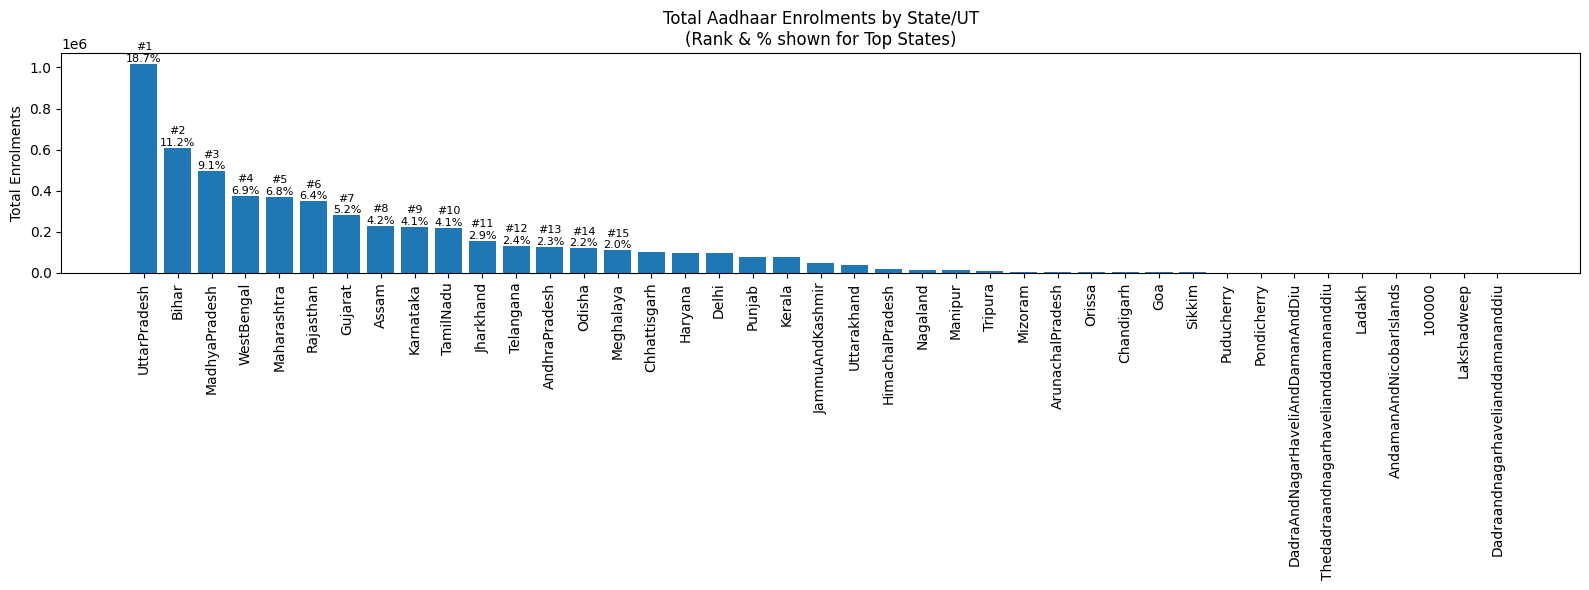

In [19]:
LABEL_TOP_K = 15
# Aggregate enrolments by state
state_enrol = (
    df_enrol
    .groupby('state')['total_enrol']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Rank
state_enrol['rank'] = (
    state_enrol['total_enrol']
    .rank(ascending=False, method='dense')
    .astype(int)
)

# Percentage contribution
total_enrolments = state_enrol['total_enrol'].sum()
state_enrol['percentage'] = (
    state_enrol['total_enrol'] / total_enrolments * 100
)

# Plot
plt.figure(figsize=(16, 6))
bars = plt.bar(range(len(state_enrol)), state_enrol['total_enrol'])

plt.xticks(
    range(len(state_enrol)),
    state_enrol['state'],
    rotation=90
)
plt.ylabel('Total Enrolments')
plt.title('Total Aadhaar Enrolments by State/UT\n(Rank & % shown for Top States)')

# ---- Add labels ONLY for top K ----
for i in range(min(LABEL_TOP_K, len(state_enrol))):
    bar = bars[i]
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"#{state_enrol.loc[i, 'rank']}\n"
        f"{state_enrol.loc[i, 'percentage']:.1f}%",
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.tight_layout()
plt.show()


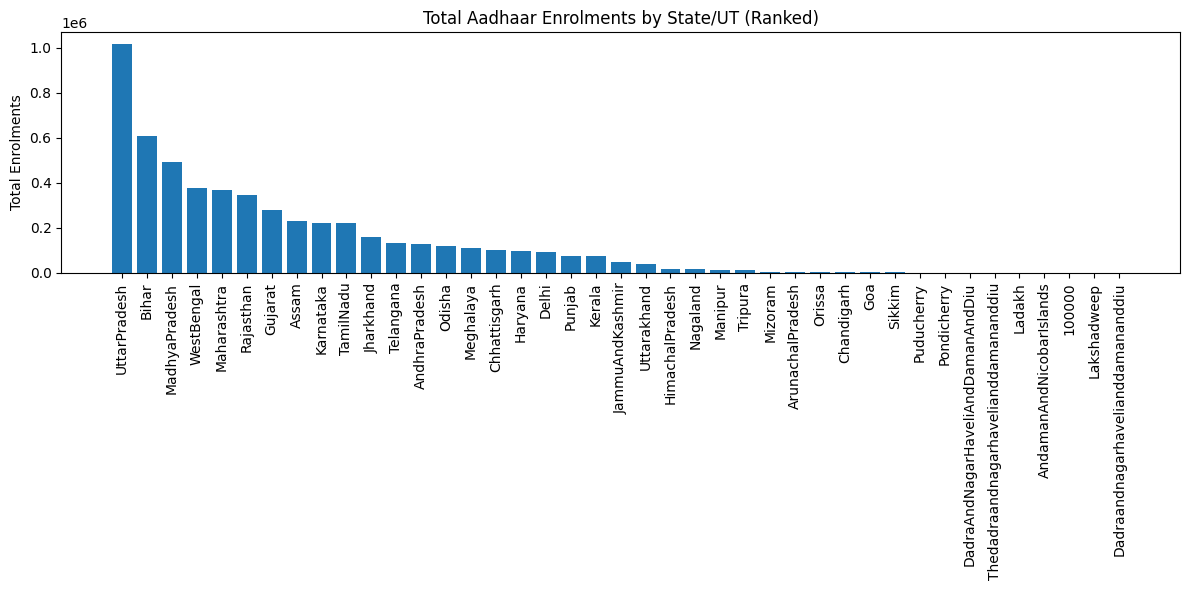

Top 5 States:
                                    state  total_enrol  rank
0                           UttarPradesh      1018629   1.0
1                                  Bihar       609585   2.0
2                          MadhyaPradesh       493970   3.0
3                             WestBengal       375340   4.0
4                            Maharashtra       369139   5.0
5                              Rajasthan       348458   6.0
6                                Gujarat       280549   7.0
7                                  Assam       230197   8.0
8                              Karnataka       223235   9.0
9                              TamilNadu       220789  10.0
10                             Jharkhand       157539  11.0
11                             Telangana       131574  12.0
12                         AndhraPradesh       127686  13.0
13                                Odisha       118838  14.0
14                             Meghalaya       109771  15.0
15                       

In [14]:
state_enrol = df_enrol.groupby('state')['total_enrol'].sum().sort_values(ascending=False).reset_index()
state_enrol['rank'] = state_enrol['total_enrol'].rank(ascending=False, method='dense')

plt.figure(figsize=(12, 6))
plt.bar(range(len(state_enrol)), state_enrol['total_enrol'])
plt.xticks(range(len(state_enrol)), state_enrol['state'], rotation=90)
plt.ylabel('Total Enrolments')
plt.title('Total Aadhaar Enrolments by State/UT (Ranked)')
plt.tight_layout()
plt.show()

print("Top 5 States:\n", state_enrol)
